In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import ipywidgets as widgets
from scipy.signal import butter, lfilter, iirpeak, iirnotch
from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import freqz
from IPython.display import display, HTML
import pyfar as pf
from functools import partial

%matplotlib widget

plt.clf()

plt.close('all')

### Import audio ###

In [2]:
audio = {}
audio["airport"] = pf.io.read_audio("./airport.wav")
audio["white_noise"] = pf.signals.noise(2**22, rms=[1, 1])
audio["jet_engine"] = pf.io.read_audio("./jet_engines.mp3")

### Define Audio Player Widgets ###

In [3]:
print(sd.query_devices())

# Play audio
def play_audio(audio, sample_rate):
    sd.play(audio.time.T, sample_rate)


# Stop audio
def stop_audio(b):
    sd.stop()



def create_play_button(description, signal):
    button = widgets.Button(description=description)
    button.layout = widgets.Layout(border='1px solid black', border_radius='10px')
    button.on_click(lambda b, audio=signal: play_audio(audio, audio.sampling_rate))
    button.layout.width = '250px'
    return button

stop_button = widgets.Button(description="Stop Audio")
stop_button.layout = widgets.Layout(border='1px solid black', border_radius='10px')
stop_button.on_click(stop_audio)


# Custom CSS to style the ipywidget buttons
custom_css = """
<style>
    .jupyter-widgets button {
        background-color: white !important;
        border: 1px solid black !important;
        border-radius: 10px !important;
        margin: 10px;
    }
    .widget-container {
        display: flex;
        flex-direction: row;
        justify-content: start;
        align-items: center;
    }
</style>
"""

# Display the custom CSS
display(HTML(custom_css))


   0 Microsoft Soundmapper - Input, MME (2 in, 0 out)
>  1 Microphone Array (AMD Audio Dev, MME (2 in, 0 out)
   2 Microsoft Soundmapper - Output, MME (0 in, 2 out)
<  3 Lautsprecher (Realtek(R) Audio), MME (0 in, 2 out)
   4 Primärer Soundaufnahmetreiber, Windows DirectSound (2 in, 0 out)
   5 Microphone Array (AMD Audio Device), Windows DirectSound (2 in, 0 out)
   6 Primärer Soundtreiber, Windows DirectSound (0 in, 2 out)
   7 Lautsprecher (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
   8 Lautsprecher (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
   9 Microphone Array (AMD Audio Device), Windows WASAPI (2 in, 0 out)
  10 Mikrofon (Realtek HD Audio Mic input), Windows WDM-KS (2 in, 0 out)
  11 Speakers 1 (Realtek HD Audio output with HAP), Windows WDM-KS (0 in, 2 out)
  12 Speakers 2 (Realtek HD Audio output with HAP), Windows WDM-KS (0 in, 2 out)
  13 PC-Lautsprecher (Realtek HD Audio output with HAP), Windows WDM-KS (2 in, 0 out)
  14 Speakers 3 (Realtek HD Audio output

No such comm: 87267af3e9bb425ea01b8986a5d32aa1


   0 Microsoft Soundmapper - Input, MME (2 in, 0 out)
>  1 Microphone Array (AMD Audio Dev, MME (2 in, 0 out)
   2 Microsoft Soundmapper - Output, MME (0 in, 2 out)
<  3 Lautsprecher (Realtek(R) Audio), MME (0 in, 2 out)
   4 Primärer Soundaufnahmetreiber, Windows DirectSound (2 in, 0 out)
   5 Microphone Array (AMD Audio Device), Windows DirectSound (2 in, 0 out)
   6 Primärer Soundtreiber, Windows DirectSound (0 in, 2 out)
   7 Lautsprecher (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
   8 Lautsprecher (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
   9 Microphone Array (AMD Audio Device), Windows WASAPI (2 in, 0 out)
  10 Mikrofon (Realtek HD Audio Mic input), Windows WDM-KS (2 in, 0 out)
  11 Speakers 1 (Realtek HD Audio output with HAP), Windows WDM-KS (0 in, 2 out)
  12 Speakers 2 (Realtek HD Audio output with HAP), Windows WDM-KS (0 in, 2 out)
  13 PC-Lautsprecher (Realtek HD Audio output with HAP), Windows WDM-KS (2 in, 0 out)
  14 Speakers 3 (Realtek HD Audio output

### Plot magnitude spectrum of different sounds ###

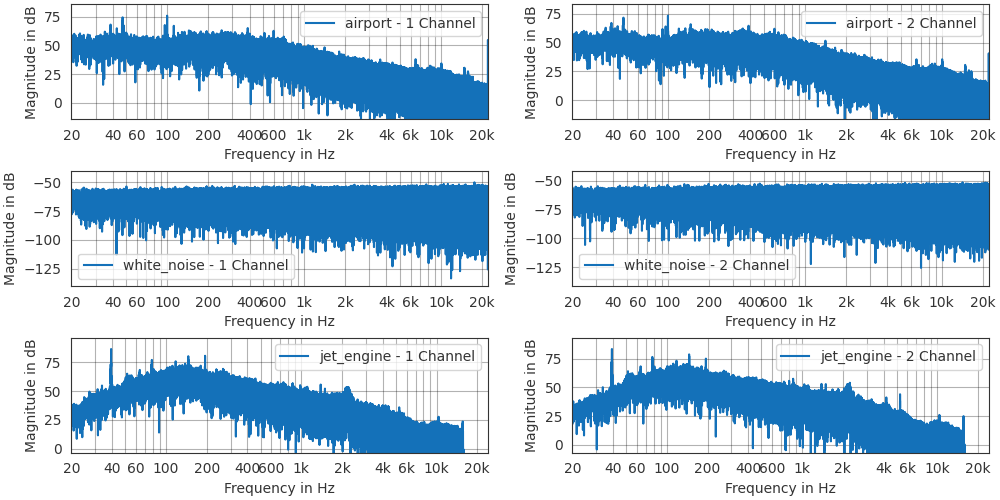

In [4]:
with pf.plot.context():
    fig, ax = plt.subplots(3, 2, figsize=(10, 5))
    row = 0
    column = 0
    for type, signal in audio.items():
        for channel in range(0, signal.cshape[0]):
            pf.plot.freq(signal[channel], label=f'{type} - {channel + 1} Channel', ax=ax[row, column])
            ax[row, column].legend()
            column += 1
        row += 1
        column = 0

### Define Filters ###

In [5]:
"""Get a FilterIIR Object representing the butterworth filter"""
def get_butterworth(signal, order, cutoff, sample_rate, btype='lowpass'):
    return pf.dsp.filter.butterworth(signal, order, cutoff, btype, sample_rate)



def get_bell(signal, center_freq, gain, bandwidth, sample_rate):
    return pf.dsp.filter.bell(signal, center_freq, gain, center_freq/bandwidth, sampling_rate=sample_rate)




### Define plotting function

In [6]:
impulse = pf.signals.impulse(2**21)
"""Plot Butterworth filter magnitude spectrum"""
def plot_butterworth():
    plt.figure("Butterworth")
    for i in range(1,10):
        butterworth= get_butterworth(None, i, 200, sample_rate=44100)
        impulse_response = butterworth.process(impulse)
        ax = pf.plot.freq(impulse_response, label=f'Butterworth {i}-Order')
    ax.legend()



"""Plot Bell Filter magnitude spectrum"""
def plot_bell():
    plt.figure("Bell Filter")
    bandwidths = [10, 50, 100]
    for bandwidth in bandwidths:
        bell = get_bell(None, 1000, -50, bandwidth, 44100)
        impulse_response= bell.process(impulse)
        ax = pf.plot.freq(impulse_response, label=f"Bandwidth: {bandwidth}")
    ax.legend()

### Butterworth Magnitude Spectrum ###

c:\Users\LinhNguyen\miniconda3\envs\test\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


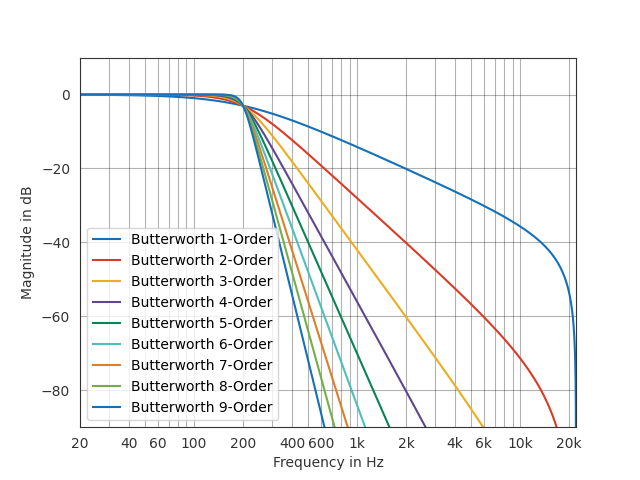

In [7]:
impulse = pf.signals.impulse(2**21)

plot_butterworth()

### Bell Filter magnitude spectrum ###

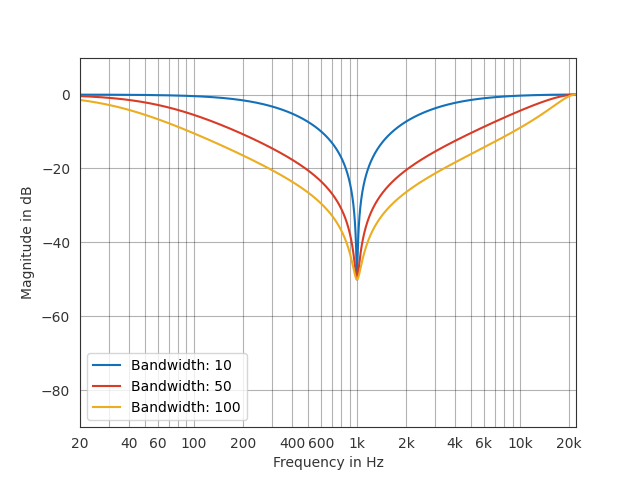

In [8]:
plot_bell()

### Apply Butterworth Filter to Different Sounds and Plot the resulting spectrum ###

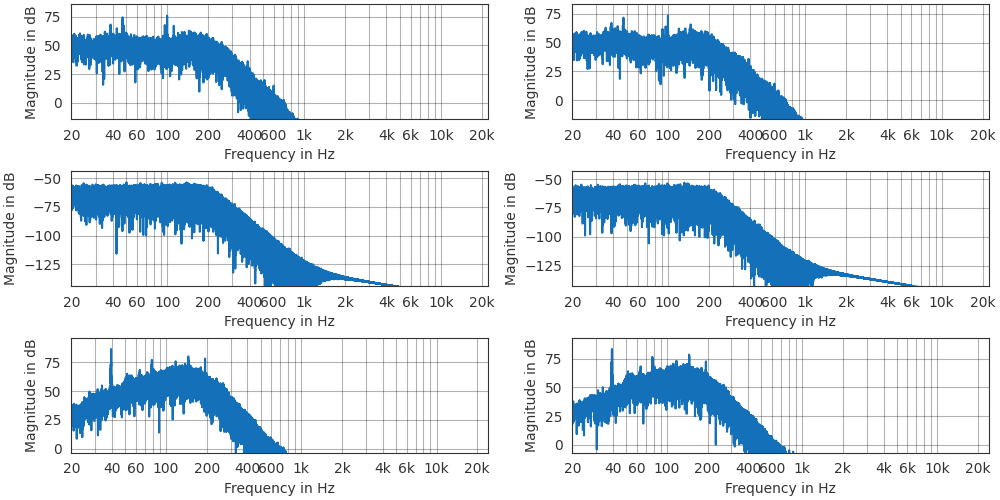

In [9]:
audio_butterworth = {}

with pf.plot.context():
    fig, ax = plt.subplots(3, 2, figsize=(10, 5))
    row = 0
    column = 0
    for type, signal in audio.items():
        signal_filtered = get_butterworth(signal, 5, 200, None)
        for channel in range(0,signal_filtered.cshape[0]):
            pf.plot.freq(signal_filtered[channel], label=f'{type}-{channel} Channel-filtered', ax=ax[row, column])
            column += 1
        column = 0
        row += 1
        audio_butterworth[f'{type}'] = signal_filtered


### Apply Bell Filter to Different Sounds and Plot the resulting spectrum ###

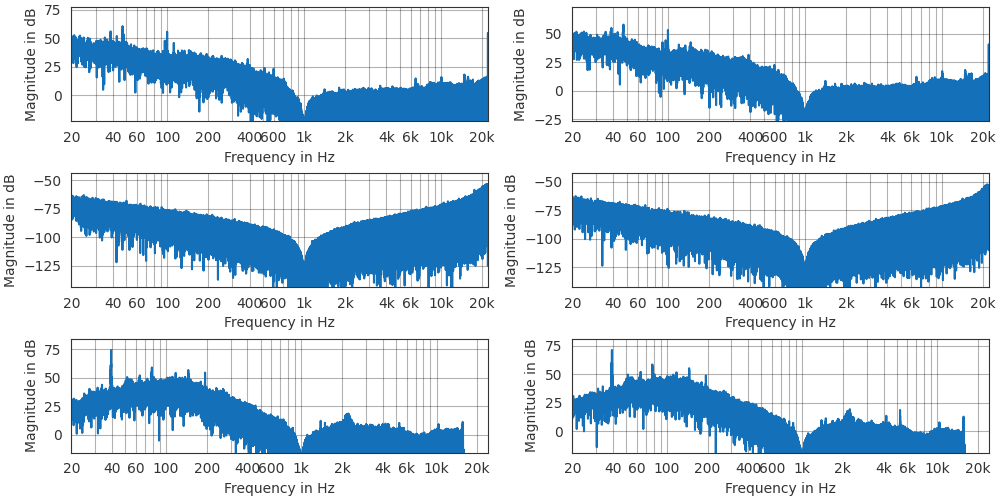

In [14]:
audio_bell = {}

with pf.plot.context():
    fig, ax = plt.subplots(3, 2, figsize=(10, 5))
    row = 0
    column = 0
    for type, signal in audio.items():
        signal_filtered = get_bell(signal, 1000, -80, 10, None)
        for channel in range(0,signal_filtered.cshape[0]):
            pf.plot.freq(signal_filtered[channel], label=f'{type}-{channel} Channel-filtered', ax=ax[row, column])
            column += 1
        column = 0
        row += 1
        audio_bell[f'{type}'] = signal_filtered


### Play original audio ###

In [11]:
for type, signal in audio.items():
    play_original = create_play_button(f"Play original {type}", signal)
    box = widgets.HBox([play_original, stop_button])
    display(box)

### Play lowpass filtered audio ###

In [12]:
for type, signal in audio_butterworth.items():
    play_original = create_play_button(f"Play low pass filtered {type}", signal)
    box = widgets.HBox([play_original, stop_button])
    display(box)

### Play bell filtered audio ###

In [13]:
for type, signal in audio_bell.items():
    play_original = create_play_button(f"Play bell filtered {type}", signal)
    box = widgets.HBox([play_original, stop_button])
    display(box)